# Effect inference with timeseries data

In this notebook, we will look at an example of causal effect inference from timeseries data. We will use DoWhy's functionality to add temporal dependencies to a causal graph and estimate causal effect based on the augmented graph.  

In [1]:
import networkx as nx
import pandas as pd
from dowhy.utils.timeseries import create_graph_from_csv,create_graph_from_user
from dowhy.utils.plotting import plot, pretty_print_graph

## Loading timeseries data and causal graph

In [2]:
dataset_path="../datasets/temporal_dataset.csv"

dataframe=pd.read_csv(dataset_path)

In temporal causal inference, accurately estimating causal effects often requires accounting for time lags between nodes in a graph. For instance, if $node_1$ influences $node_2$ with a time lag of 5 timestamps, we represent this dependency as $node_1^{t-5}$ -> $node_2^{t}$.

We can provide the causal graph as a networkx DAG or as a dot file. The edge attributes should mention the exact `time_lag` that is associated with each edge (if any).

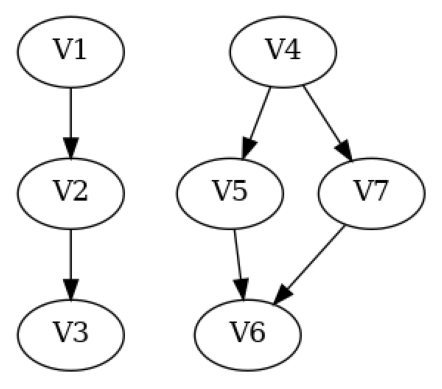

In [3]:
from dowhy.utils.timeseries import create_graph_from_dot_format

file_path = "../datasets/temporal_graph.dot"

graph = create_graph_from_dot_format(file_path)
plot(graph)


We can also create a csv file with the edges in the temporal graph. The columns in the csv are node1, node2, time_lag which represents an directed edge node1 -> node2 with the time lag of time_lag. Let us consider the following graph as the input:

| node1  | node2  | time_lag |
|--------|--------|----------|
| V1     | V2     | 3        |
| V2     | V3     | 4        |
| V5     | V6     | 1        |
| V4     | V7     | 4        |
| V4     | V5     | 2        |
| V7     | V6     | 3        |
| V7     | V6     | 5        |

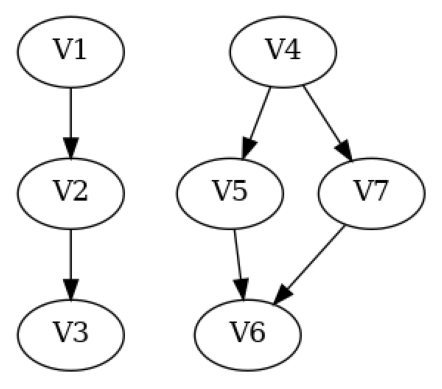

In [4]:
# Input a csv file with the edges in the graph with the columns: node_1,node_2,time_lag
file_path = "../datasets/temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
plot(graph)

## Dataset Shifting and Filtering

To prepare the dataset for temporal causal inference, we need to shift the columns by the given time lag.

For example, in the causal graph above, $node_1^{t-5}$ -> $node_2^{t}$ with a lag of 5. When considering $node_2$ as the target node, the data for $node_1$ should be shifted down by 5 timestamps. This adjustment ensures that the edge $node_1$ -> $node_2$ accurately represents the lagged dependency. Shifting the data in this manner creates additional columns and allows downstream estimators to acccess the correct values in the same row of a dataframe. 

In [5]:
from dowhy.timeseries.temporal_shift import shift_columns_by_lag_using_unrolled_graph, add_lagged_edges

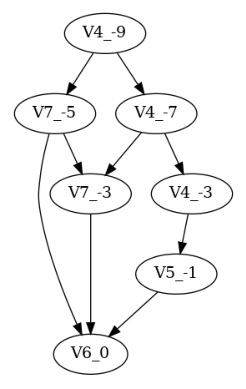

In [6]:
# the outcome node for which effect estimation has to be done, node:6
target_node = 'V6'
unrolled_graph = add_lagged_edges(graph, target_node)
plot(unrolled_graph)

In [7]:
time_shifted_df = shift_columns_by_lag_using_unrolled_graph(dataframe, unrolled_graph)
time_shifted_df.head()

V6_0  V5_-1  V7_-3  V7_-5  V4_-3  V4_-9  V4_-7
0     6      0      0      0      0      0      0
1     7      5      0      0      0      0      0
2     8      6      0      0      0      0      0
3     9      7      7      0      4      0      0
4     9      8      8      0      5      0      0

## Causal Effect Estimation

Once you have the new dataframe, causal effect estimation can be performed on the target node with respect to the action nodes.

In [8]:
target_node = 'V6_0'
# include all the treatments
treatment_columns = list(time_shifted_df.columns)
treatment_columns.remove(target_node)
treatment_columns

['V5_-1', 'V7_-3', 'V7_-5', 'V4_-3', 'V4_-9', 'V4_-7']

In [9]:
# perform causal effect estimation on this new dataset
import dowhy
from dowhy import CausalModel

model = CausalModel(
    data=time_shifted_df,
    treatment='V5_-1',
    outcome=target_node,
    graph = unrolled_graph
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True)


print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                    
────────(E[V_6_0|V4_-3])
d[V₅ ₋₁]                
Estimand assumption 1, Unconfoundedness: If U→{V5_-1} and U→V6_0 then P(V6_0|V5_-1,V4_-3,U) = P(V6_0|V5_-1,V4_-3)

## Realized estimand
b: V6_0~V5_-1+V4_-3+V5_-1*V7_-3+V5_-1*V7_-5
Target units: 

## Estimate
Mean value: -0.008318651389864762
p-value: [0.75812695]
### Conditional Estimates
__categorical__V7_-3  __categorical__V7_-5
(-0.001, 0.6]         (-0.001, 5.4]           0.101279
(0.6, 5.4]            (7.8, 9.0]             -0.167641
                      (9.0, 10.0]            -0.167956
(5.4, 7.8]            (-0.001, 5.4]           0.175782
                      (7.8, 9.0]             -0.114425
(7.8, 9.0]            (-0.001, 5.4]           0.111134
                      (5.4, 7.8]             -0.028648
                      (7.8, 9.0]             -0.09

/github/home/.cache/pypoetry/virtualenvs/dowhy-oN2hW5jr-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Importing temporal causal graph from Tigramite library

Tigramite is a popular temporal causal discovery library. In this section, we highlight how the causal graph can be obtained by applying PCMCI+ algorithm from tigramite and imported into DoWhy.

In [10]:
!pip install tigramite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/309.6 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 5.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import tigramite
import tigramite.data_processing as pp
import matplotlib.pyplot as plt
import pandas as pd

dataframe = dataframe.astype(float)
var_names = dataframe.columns
# convert the dataframe values to float
dataframe = pp.DataFrame(dataframe.values, var_names=var_names)

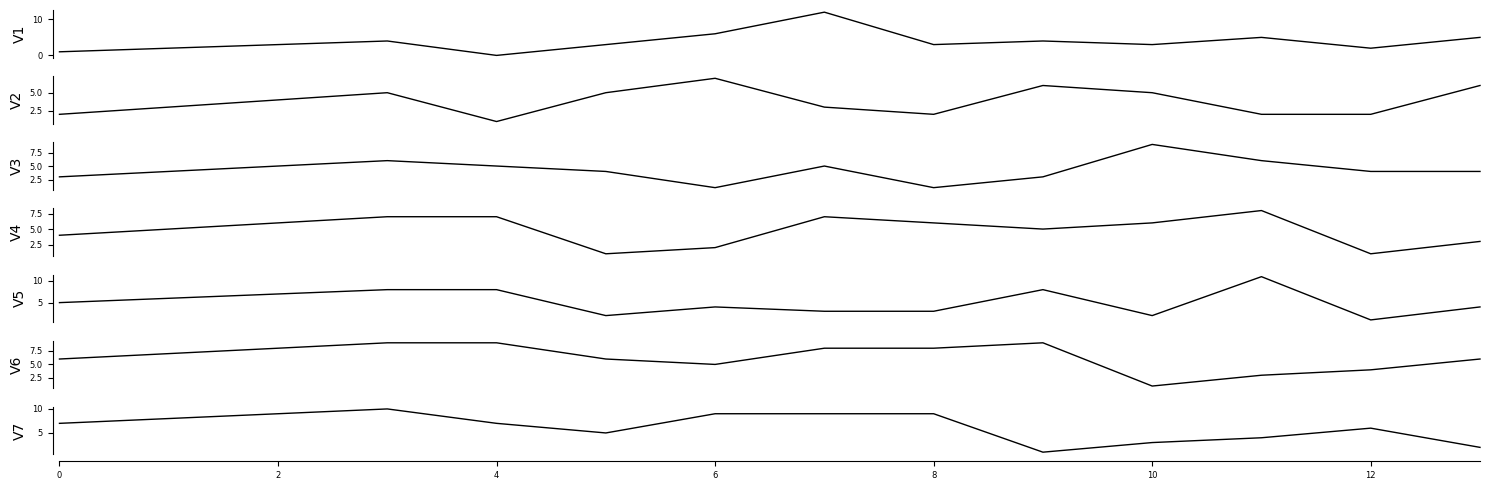

In [12]:
from tigramite import plotting as tp
tp.plot_timeseries(dataframe, figsize=(15, 5)); plt.show()

In [13]:
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import numpy as np
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

In [14]:
correlations = pcmci.run_bivci(tau_max=3, val_only=True)['val_matrix']
matrix_lags = np.argmax(np.abs(correlations), axis=2)


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 3


In [15]:
tau_max = 3
pc_alpha = None
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Optimizing pc_alpha over pc_alpha_list = [0.001, 0.005, 0.01, 0.025, 0.05]
##

## pc_alpha = 0.001 (1/5):

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.001]
max_conds_dim = None
max_combinations = 1



## Variable V1

Iterating through pc_alpha = [0.001]:

# pc_alpha = 0.001 (1/1):

Testing condition sets of dimension 0:

    Link (V1 -1) -?> V1 (1/21):
    Subset 0: () gives pval = 0.86601 / val = -0.072
    Non-significance detected.

    Link (V1 -2) -?> V1 (2/21):
    Subset 0: () gives pval = 0.57469 / val = -0.235
    Non-significance detected.

    Link (V1 -3) -?> V1 (3/21):
    Subset 0: () gives pval = 0.13528 / val = -0.576
    Non-significance detected.

    Link (V2 -1) -?> V1 (4/21):
    Subset 0: () gives pval = 0.08631 / val =  0.642
    Non-significance detected.

    Link (V2 -2) -?> V1 (5/21):
    Subset 0: () gives pval = 1.00000 / val = -0.000
    Non-significan

    Subset 0: () gives pval = 0.40658 / val =  0.342
    Non-significance detected.

    Link (V2 -1) -?> V2 (4/21):
    Subset 0: () gives pval = 0.87285 / val = -0.068
    Non-significance detected.

    Link (V2 -2) -?> V2 (5/21):
    Subset 0: () gives pval = 0.00058 / val = -0.938
    No conditions of dimension 0 left.

    Link (V2 -3) -?> V2 (6/21):
    Subset 0: () gives pval = 0.38647 / val =  0.356
    Non-significance detected.

    Link (V3 -1) -?> V2 (7/21):
    Subset 0: () gives pval = 0.18843 / val = -0.518
    Non-significance detected.

    Link (V3 -2) -?> V2 (8/21):
    Subset 0: () gives pval = 0.82124 / val =  0.096
    Non-significance detected.

    Link (V3 -3) -?> V2 (9/21):
    Subset 0: () gives pval = 0.25844 / val =  0.454
    Non-significance detected.

    Link (V4 -1) -?> V2 (10/21):
    Subset 0: () gives pval = 0.08165 / val = -0.649
    Non-significance detected.

    Link (V4 -2) -?> V2 (11/21):
    Subset 0: () gives pval = 0.06607 / val =  0.675
 

    Subset 0: () gives pval = 0.42452 / val = -0.330
    Non-significance detected.

    Link (V4 -3) -?> V6 (12/21):
    Subset 0: () gives pval = 0.11568 / val = -0.600
    Non-significance detected.

    Link (V5 -1) -?> V6 (13/21):
    Subset 0: () gives pval = 0.26711 / val = -0.447
    Non-significance detected.

    Link (V5 -2) -?> V6 (14/21):
    Subset 0: () gives pval = 0.73415 / val = -0.144
    Non-significance detected.

    Link (V5 -3) -?> V6 (15/21):
    Subset 0: () gives pval = 0.89556 / val =  0.056
    Non-significance detected.

    Link (V6 -1) -?> V6 (16/21):
    Subset 0: () gives pval = 0.59685 / val =  0.222
    Non-significance detected.

    Link (V6 -2) -?> V6 (17/21):
    Subset 0: () gives pval = 0.75751 / val = -0.131
    Non-significance detected.

    Link (V6 -3) -?> V6 (18/21):
    Subset 0: () gives pval = 0.41015 / val = -0.340
    Non-significance detected.

    Link (V7 -1) -?> V6 (19/21):
    Subset 0: () gives pval = 0.00000 / val =  0.992
   

    Subset 0: () gives pval = 0.56354 / val =  0.242
    Non-significance detected.

    Link (V1 -2) -?> V4 (2/21):
    Subset 0: () gives pval = 0.58558 / val =  0.229
    Non-significance detected.

    Link (V1 -3) -?> V4 (3/21):
    Subset 0: () gives pval = 0.96166 / val = -0.020
    Non-significance detected.

    Link (V2 -1) -?> V4 (4/21):
    Subset 0: () gives pval = 0.16299 / val =  0.544
    Non-significance detected.

    Link (V2 -2) -?> V4 (5/21):
    Subset 0: () gives pval = 0.24064 / val =  0.469
    Non-significance detected.

    Link (V2 -3) -?> V4 (6/21):
    Subset 0: () gives pval = 0.06141 / val = -0.684
    Non-significance detected.

    Link (V3 -1) -?> V4 (7/21):
    Subset 0: () gives pval = 0.94919 / val =  0.027
    Non-significance detected.

    Link (V3 -2) -?> V4 (8/21):
    Subset 0: () gives pval = 0.02698 / val = -0.765
    Non-significance detected.

    Link (V3 -3) -?> V4 (9/21):
    Subset 0: () gives pval = 0.35707 / val = -0.377
    Non-sig

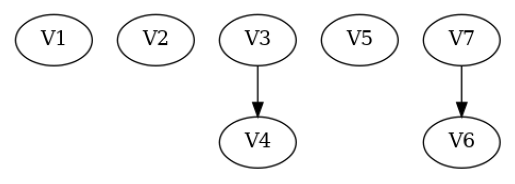

In [16]:
from dowhy.utils.timeseries import create_graph_from_networkx_array

graph = create_graph_from_networkx_array(results['graph'], var_names)

plot(graph)